# HW - 4

## Data preparation

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import KFold

In [62]:
# read csv file
df = pd.read_csv("course_lead_scoring.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [63]:
"""
Check if the missing values are presented in the features.
If there are missing values:
For categorical features, replace them with 'NA'
For numerical features, replace with 0.0
"""

for col in df.columns:
    if (df[col].dtype == 'object'):
        df[col] = df[col].fillna('NA')
    else:
        df[col] = df[col].fillna(0.0)

df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [64]:
"""
Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1
"""

seed = 1
d_test = 0.2
d_val = 0.2

# drop 'converted' col from df
df_train_val, df_test = train_test_split(df.drop(columns='converted'), test_size=d_test, random_state=seed)
df_train, df_val = train_test_split(df_train_val, test_size=d_val, random_state=seed)

print(f'Shape of full training set: {df_train_val.shape}')
print(f'Shape of validation set: {df_val.shape}')
print(f'Shape of test set: {df_test.shape}')

Shape of full training set: (1169, 8)
Shape of validation set: (234, 8)
Shape of test set: (293, 8)


## Question 1: ROC AUC feature importance

In [65]:
"""
ROC AUC could also be used to evaluate feature importance of numerical variables. Let's do that-
For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
Use the training dataset for that.
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['balance'])
"""

df_train_numerical_col = df_train.select_dtypes(exclude="object")
df_converted = df['converted'].iloc[df_train.index]
max_auc = {'column': None, 'auc': -1}

for col in df_train_numerical_col.columns:
    fpr, tpr, thresholds = roc_curve(df_converted, df_train_numerical_col[col])
    auc_value = metrics.auc(fpr, tpr)
    print(f'{col}: {auc_value:.4f}')

    if auc_value > max_auc['auc']:
        max_auc['column'] = col
        max_auc['auc'] = auc_value

print("\nBest column by AUC:")
print(max_auc)

number_of_courses_viewed: 0.7656
annual_income: 0.5524
interaction_count: 0.7309
lead_score: 0.6077

Best column by AUC:
{'column': 'number_of_courses_viewed', 'auc': np.float64(0.7656440135120665)}


## Question 2: Training the model

In [66]:
"""
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
What's the AUC of this model on the validation dataset? (round to 3 digits)
0.32
0.52
0.72
0.92
"""
numerical = df_train.select_dtypes(include="number").columns.to_list()
categorical = df_train.select_dtypes(exclude="number").columns.to_list()
features = categorical + numerical

train_dict = df_train[features].to_dict(orient="records")
val_dict = df_val[features].to_dict(orient="records")
test_dict = df_test[features].to_dict(orient="records")

dv = DictVectorizer(sparse=False)

# X_train, X_val, X_test are numpy array now
X_train = dv.fit_transform(X=train_dict)
X_val = dv.transform(X=val_dict)
X_test = dv.transform(X=test_dict)

# As X_train is numpy array, so we have to convert y_train as numpy array
y_train = df.converted[df_train.index].to_numpy()
y_val = df.converted[df_val.index].to_numpy()
y_test = df.converted[df_test.index].to_numpy()

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_val)[:, 1]

# Calculate AUC
auc = roc_auc_score(y_val, y_pred_proba)
print("AUC on validation set:", auc)

AUC on validation set: 0.8060745924216483


## Question 3: Precision and Recall

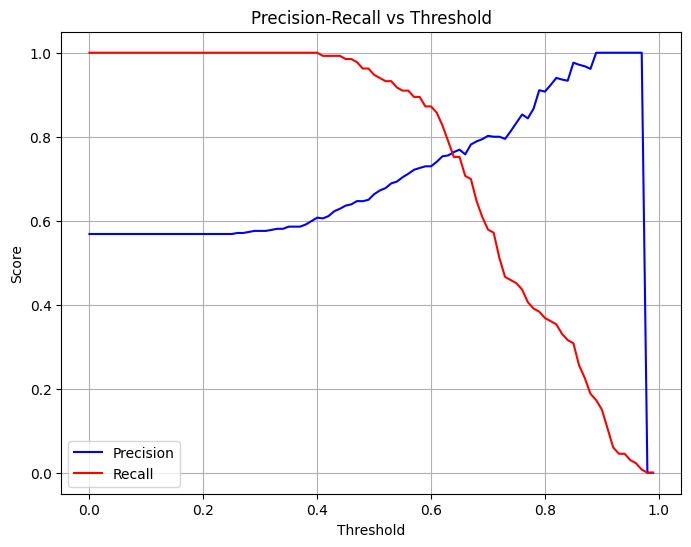

Threshold where precision and recall curves intersect: 0.635


In [67]:
"""
Now let's compute precision and recall for our model.
Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
"""

# threshold values
thresholds = np.arange(0, 1.0, 0.01)
precisions = []
recalls = []

for threshold in thresholds:
    y_pred_boolean = (y_pred_proba >= threshold)
    precisions.append(precision_score(y_val, y_pred_boolean, zero_division=0))
    recalls.append(recall_score(y_val, y_pred_boolean, zero_division=0))

# plot
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='red')
plt.title('Precision-Recall vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

"""
precision and recall are arrays of discrete sampled values, not continuous functions.
That means:
You have precision[i] and recall[i] at thresholds like 0.00, 0.01, 0.02, ... 1.00.
These values rarely exactly equal each other (like 0.7423 ≠ 0.7424).
So, precision[i] == recall[i] will almost never be true,
even though they visually cross on the graph.

difference = [ 0.2, 0.1, -0.1, -0.3 ]
np.sign(difference) → [  1,  1, -1, -1 ]

np.diff([ 1, 1, -1, -1 ]) → [ 0, -2, 0 ]
→ The -2 appears exactly where the sign changes from positive to negative.
(Similarly, +2 appears when it changes from negative to positive.)

np.where(...)[0]

Finds the indices where the change occurred —
i.e., where the two curves intersect (cross each other).
"""
precisions = np.array(precisions)
recalls = np.array(recalls)
difference = precisions - recalls

# the intersection point is where the difference is exactly zero.
intersection_indices = np.where(np.diff(np.sign(difference)))[0]

if intersection_indices.size > 0:
    intersection_threshold = (thresholds[intersection_indices] + thresholds[intersection_indices + 1]) / 2
    print(f'Threshold where precision and recall curves intersect: {intersection_threshold[0]:.3f}')
else:
    print('No intersection found within the thresholds.')

## Question 4: F1 score


Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$
F1 = \frac{2 \cdot \text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

Where 
P is precision and 
R is recall.


In [68]:
f1_scores = []

for threshold in thresholds:
    y_pred_boolean = (y_pred_proba >= threshold)
    f1_scores.append(f1_score(y_val, y_pred_boolean, zero_division=0))

max_idx = np.argmax(f1_scores)
max_threshold = thresholds[max_idx]
print(f'F1 is maximum for this {max_threshold} threshold value.')

F1 is maximum for this 0.58 threshold value.


## Question 5: 5-Fold CV

In [76]:
"""
Fold -->	A chunk/partition of the data	
Split -->	One training-validation separation

A fold is one partition (or chunk) of your dataset created for cross-validation.
If you say 5 folds, you mean:
“My data is divided into 5 equal parts (folds).”

A split refers to one iteration of training/validation separation during cross-validation.
For example, in 5-fold cross-validation:
You train on 4 folds and validate on 1 fold.
That’s 1 split (1 training-validation pair).
Then you rotate the validation fold and repeat:
Total 5 splits (because there are 5 folds → each fold gets to be validation once).

What happens when shuffle=True
Then, before splitting, scikit-learn:
Randomly shuffles all 5000 indices.
Then, it divides the shuffled order into 5 folds of 1000 each.
fold1 = [random 1000 indices]
fold2 = [random 1000 indices]
fold3 = [random 1000 indices]
fold4 = [random 1000 indices]
fold5 = [random 1000 indices]
"""
X_full_train = dv.fit_transform(df_train_val[categorical + numerical].to_dict(orient='records'))
y_full_train = df['converted'].loc[df_train_val.index].values

kf = KFold(n_splits=5, shuffle=True, random_state=1)

auc_scores = []

for train_index, val_index in kf.split(X_full_train):
    X_train, X_val = X_full_train[train_index], X_full_train[val_index]
    y_train, y_val = y_full_train[train_index], y_full_train[val_index]

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_pred)
    auc_scores.append(auc)
    print(f'AUC for this fold: {auc:.3f}')

std_auc = np.std(auc_scores)
print(f'Standard deviation of AUC scores: {std_auc:.3f}')

AUC for this fold: 0.806
AUC for this fold: 0.871
AUC for this fold: 0.775
AUC for this fold: 0.802
AUC for this fold: 0.856
Standard deviation of AUC scores: 0.036


## Question 6: Hyperparameter Tuning

In [77]:
C_values = [0.000001, 0.001, 1]
kf = KFold(n_splits=5, shuffle=True, random_state=1)

auc_scores = {}

for C in C_values:
    fold_auc_scores = []

    for train_index, val_index in kf.split(X_full_train):
        X_train, X_val = X_full_train[train_index], X_full_train[val_index]
        y_train, y_val = y_full_train[train_index], y_full_train[val_index]

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        fold_auc_scores.append(auc)

    mean_auc = np.mean(fold_auc_scores)
    std_auc = np.std(fold_auc_scores)

    auc_scores[C] = (mean_auc, std_auc)

    print(f'C: {C}, Mean AUC: {mean_auc:.4f}, Std AUC: {std_auc:.4f}')

C: 1e-06, Mean AUC: 0.5602, Std AUC: 0.0238
C: 0.001, Mean AUC: 0.8669, Std AUC: 0.0287
C: 1, Mean AUC: 0.8221, Std AUC: 0.0358


In [78]:
best_c = None
best_mean_auc = -np.inf
best_std_auc = np.inf

for C, (mean_auc, std_auc) in auc_scores.items():
    if (mean_auc > best_mean_auc) or (mean_auc == best_mean_auc and std_auc < best_std_auc) or (mean_auc == best_mean_auc and std_auc == best_std_auc and (best_c is None or C < best_c)):
        best_mean_auc = mean_auc
        best_std_auc = std_auc
        best_c = C

print(f'The best C is: {best_c} with Mean AUC: {best_mean_auc:.4f} and Std AUC: {best_std_auc:.4f}')

The best C is: 0.001 with Mean AUC: 0.8669 and Std AUC: 0.0287
